In [192]:
# Machine Learning Engineering HW #3
# Nicholas March
# 661848406

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.patches as mpatches
%matplotlib inline
#%matplotlib notebook
import tensorflow as tf
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from tensorflow.python.keras.optimizers import *
from sklearn.metrics import r2_score

Initial Image Array Shape: (194, 259, 3)
Flattened Image Array Shape: (50246, 3)
Silhouette Training Array Shape: (35172, 3)


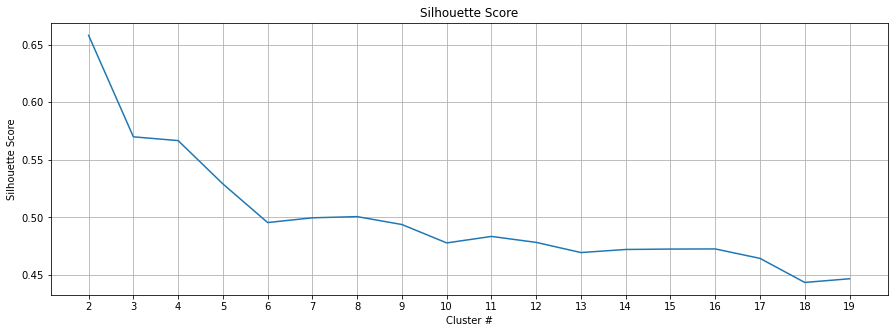

Optimal Cluster # based on Silhouette Score: 4


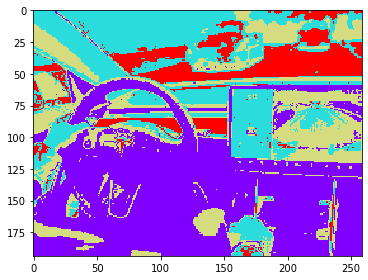

In [193]:
# Problem 1

# Upload and format image data
import skimage.io as skim
image_pre = np.array(skim.imread('seg2.jpg')) # initial input image matrix
print("Initial Image Array Shape:",image_pre.shape)
image = [] # flattened image matrix
for i in range(len(image_pre)):
    for j in range(len(image_pre[0])):
        image.append(image_pre[i][j])
image = np.array(image)
print("Flattened Image Array Shape:",image.shape)
sample_size = int(0.70 * len(image)) 
indices = np.random.choice(len(image), sample_size, replace=False) # selects random indices throughout data
image_silh = image[indices] # array containing 70% of total data, used for silhouette score calculation
print("Silhouette Training Array Shape:",image_silh.shape)

# Determine silhouette score to optimize k-means model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
silhouette_scores = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k,init='k-means++', n_jobs=-1)
    kmeans.fit(image_silh)
    silhouette_scores.append(silhouette_score(image_silh, kmeans.labels_))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), silhouette_scores)
plt.grid(True)
plt.xticks(ticks = range(2, 20))
plt.title('Silhouette Score')
plt.xlabel('Cluster #')
plt.ylabel('Silhouette Score')
plt.show()

# Define optimized sklearn k-means model based on silhouette score
k = 4
print("Optimal Cluster # based on Silhouette Score:",k)
skmodel = KMeans(
    n_clusters=k,
    init='k-means++',
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='auto',
)

# Implement sklearn k-means model
skmodel.fit(image)
sklearn_labels = skmodel.predict(image)
centroids  = skmodel.cluster_centers_

# Define coloring scheme
colors = list(plt.cm.rainbow(np.linspace(0, 1, k)))
colors_rgb = []
for color in colors:
    colors_rgb.append(list(np.array(cl.to_rgb(color))*255.0))
    
# Implement coloring scheme
segmented_img = np.copy(image_pre)
for i in range(len(segmented_img)):
    for j in range(len(segmented_img[0])):
        n = (i * len(segmented_img[0])) + j
        label = sklearn_labels[n]
        segmented_img[i][j] = colors_rgb[label]

# Display segmented image
skim.imshow(segmented_img)

Population Array Shape: (97, 1)
Price Array Shape: (97, 1)


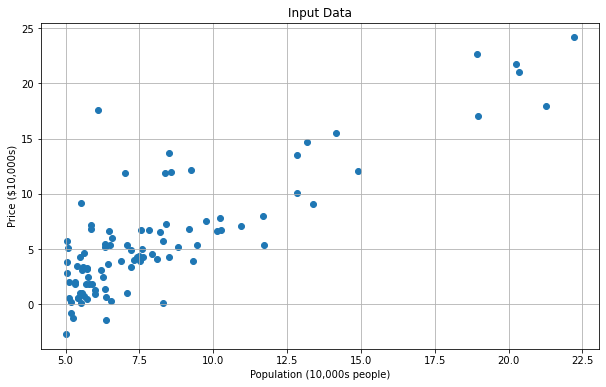

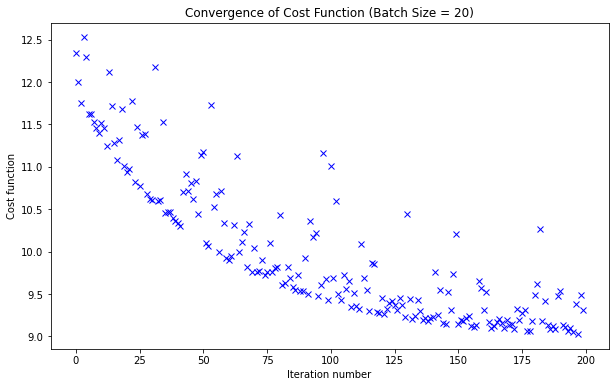

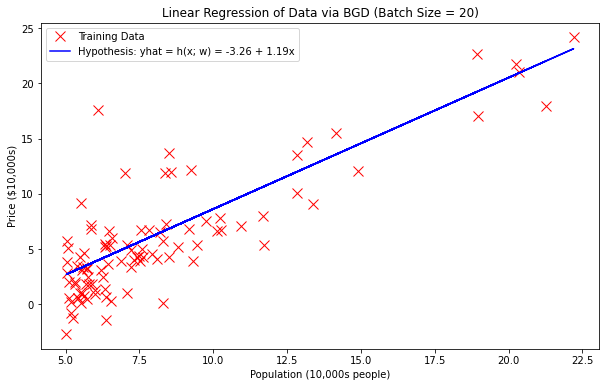


R-squared score: 0.6902
Predicted Price of House in City with Population of 160,000: $157558.97


In [188]:
# Problem 2

# Upload and format data
f = open("pop_data.txt", "r")
data = f.read().splitlines()[1:]
pop = []
price = []
for tup in data:
    splt = tup.split(",")
    pop.append(float(splt[0]))
    price.append(float(splt[1]))
pop = np.reshape(np.array(pop), (len(pop), 1))
price = np.reshape(np.array(price), (len(price), 1))
print("Population Array Shape:",pop.shape)
print("Price Array Shape:",price.shape)
f.close()

# Plot input data
fig = plt.figure(figsize=(10, 6))
plt.scatter(pop, price)
plt.grid(True)
plt.title('Input Data')
plt.ylabel('Price ($10,000s)')
plt.xlabel('Population (10,000s people)')
plt.show()

# Define model function
def h(w, X):
    return np.dot(X,w)

# Define error measure function
def mse(w,X,y,m):
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    return float((1./(2*m)) * np.dot((h(w,X_bias)-y).T,(h(w,X_bias)-y)))

# Define gradient descent function
def mb_gradient_descent(X, y, batch_size, w_start=np.zeros(2), iterations=200, alpha=0.01):
    w = w_start
    m = len(X)  # total number of data points
    J_values = []
    w_store = []
    for it in range(iterations):
        shuffled_indices = np.random.permutation(m)
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            m_batch = len(X_batch) # number of data points in batch
            predictions = w[0] + w[1] * X_batch
            w[0] = w[0] - alpha * (1/m_batch) * np.sum(predictions - y_batch)
            w[1] = w[1] - alpha * (1/m_batch) * np.sum((predictions - y_batch) * X_batch)        
        J = np.mean((w[0] + w[1] * X - y) ** 2)
        J_values.append(J)
        w_store.append(w.copy())
    return w, w_store, J_values

# Define predictor function
def predict(xval, w):
    return w[0] + w[1]*xval

# Implement gradient descent with batch size = 20
w, w_store, J_values = mb_gradient_descent(pop, price, 20)
pred = predict(pop[:,0], w)

# Plot cost function
plt.figure(figsize=(10,6))
plt.plot(range(len(J_values)),J_values,'bx')
plt.title("Convergence of Cost Function (Batch Size = 20)")
plt.xlabel("Iteration number")
plt.ylabel("Cost function")
plt.show()

# Plot data and linear regression
plt.figure(figsize=(10,6))
plt.plot(pop[:,0],price[:,0],'rx',markersize=10,label='Training Data')
plt.plot(pop[:,0],pred,'b-',label = 'Hypothesis: yhat = h(x; w) = %0.2f + %0.2fx'%(w[0],w[1]))
plt.ylabel('Price ($10,000s)')
plt.xlabel('Population (10,000s people)')
plt.title("Linear Regression of Data via BGD (Batch Size = 20)")
plt.legend()
plt.show()

# Make prediction and output
x_test_ind = 16.0
y_test_ind = predict(x_test_ind, w)
r2 = round(r2_score(price[:,0], pred),4)
print('\nR-squared score:', r2)
print("Predicted Price of House in City with Population of 160,000: $"+str(round(y_test_ind*10000.0,2)))

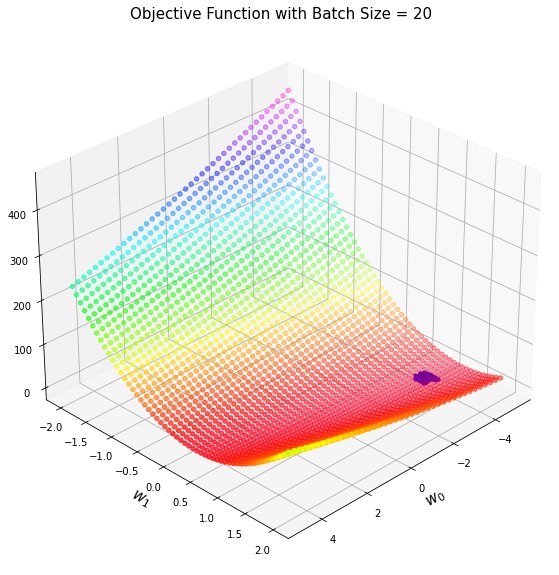

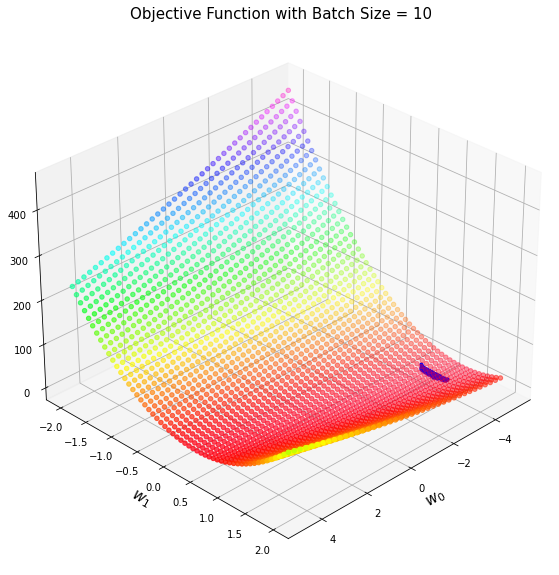

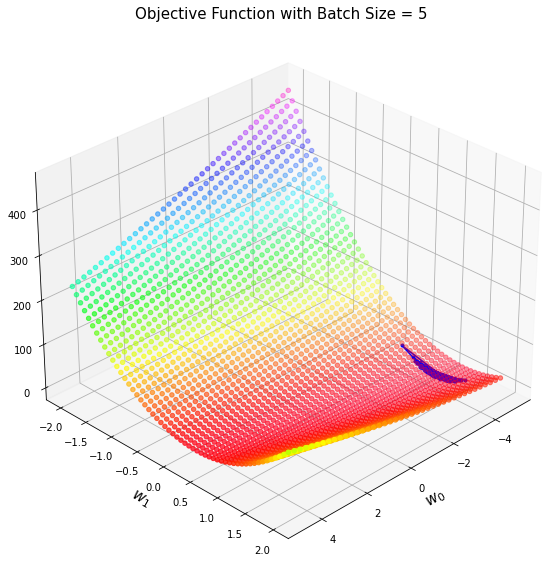

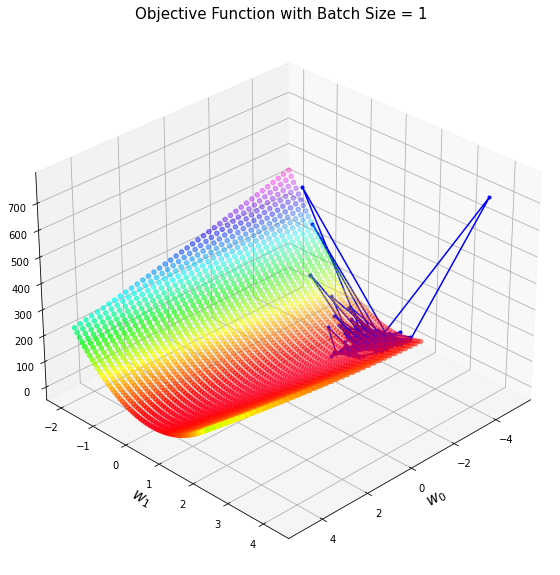

In [189]:
# Problem 2 (Continued) 

# Define objective function plotter
def obj_fxn_plotter(pop, price, batch_size):
    w, w_store, J_values = mb_gradient_descent(pop, price, batch_size)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection = '3d')
    ax = fig.gca()
    elevation_angle = 30
    azimuth_angle = 45
    ax.view_init(elev=elevation_angle, azim=azimuth_angle)
    xvals = np.arange(-5,5,.25)
    yvals = np.arange(-2,2,.075)
    myxs, myys, myzs = [], [], []
    for _ in xvals:
        for _k in yvals:
            myxs.append(_)
            myys.append(_k)
            myzs.append(mse(np.array([[_], [_k]]),pop,price,pop.size))
    scat = ax.scatter(myxs,myys,myzs,c=np.abs(myzs),cmap=plt.get_cmap('gist_rainbow'))
    plt.xlabel(r'$w_0$',fontsize=15)
    plt.ylabel(r'$w_1$',fontsize=15)
    plt.title(str('Objective Function with Batch Size = '+str(batch_size)),fontsize=15)
    w_0 = np.array(w_store)[:,0]
    w_1 = np.array(w_store)[:,1]
    plt.plot(w_0, w_1, J_values,'bo-', markersize=3)
    plt.show()

# Plot objective functions
obj_fxn_plotter(pop, price, 20)
obj_fxn_plotter(pop, price, 10)
obj_fxn_plotter(pop, price, 5)
obj_fxn_plotter(pop, price, 1)

Using a batch size of one for training causes very noisy updates to the model's
parameters. This is due to each update being based on just one data point, like
in stochastic gradient descent, making the path to the best solution erratic and
potentially longer. This could be beneficial, as the random and chaotic jumps help
to avoid local minima. On the other hand, it will require more epochs for convergence

Ratio of Malignancies to Benign Data Points: 0.5938375350140056
If not ~ 1, indicates imbalanced dataset

Feature Data Matrix Shape: (569, 10)
Label Data Array Shape: (569,)

Original Features: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

True/False Selection of features: [False False False False False False  True  True False False]

The best features are: ['concavity_mean' 'concave points_mean']


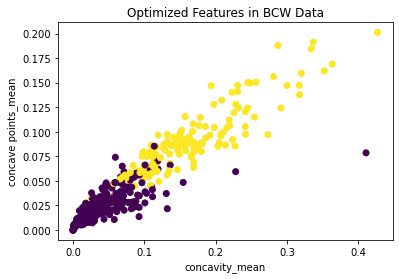


Optimized Training Feature Matrix Shape: (398, 2)
Optimized Test Feature Matrix Shape: (171, 2)

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67       108
           1       0.49      0.63      0.55        63

    accuracy                           0.62       171
   macro avg       0.61      0.62      0.61       171
weighted avg       0.65      0.62      0.63       171



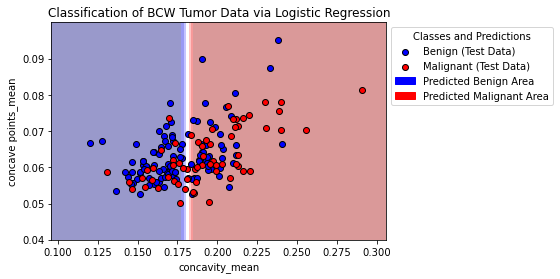

In [182]:
# Problem 3

# Upload and format BCW data
f2 = open("bcw_data.csv", "r")
feature_names = f2.readline().strip().split(",")[1:]
X = []
y = []
malignant = 0.0
benign = 0.0
for line in f2:
    splt = line.strip().split(",")
    if splt[0] == "M":     # Redefine y-label, malignant==1, benign==0
        malignant += 1.0
        y.append(1)
    elif splt[0] == "B":
        benign += 1.0
        y.append(0)
    X.append(np.array(splt[1:]).astype(float))
f2.close()
X = np.array(X)
y = np.array(y)
print("Ratio of Malignancies to Benign Data Points:",(malignant / benign))
print("If not ~ 1, indicates imbalanced dataset")
print("\nFeature Data Matrix Shape:",X.shape)
print("Label Data Array Shape:",y.shape)
print("\nOriginal Features:",feature_names)
  
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Import and implement recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(lr, n_features_to_select=2)
rfe = rfe.fit(X_train, y_train)
print('\nTrue/False Selection of features:', rfe.support_)
feature_indices = np.array([0,1,2,3,4,5,6,7,8,9])
feature_indices = feature_indices[rfe.support_]
plt.scatter(X_train[:,feature_indices[0]], X_train[:,feature_indices[1]], c =y_train)
plt.xlabel(feature_names[feature_indices[0]])
plt.ylabel(feature_names[feature_indices[1]])
plt.title("Optimized Features in BCW Data")
print('\nThe best features are:', np.array(feature_names)[rfe.support_])
plt.show()

# Format selected feature training and testing data
i = 0
while(X_test.shape[1] > len(feature_indices) and X_train.shape[1] > len(feature_indices)):
    if i not in feature_indices:
        X_test = np.delete(X_test, i, 1)
        X_train = np.delete(X_train, i, 1)
    else:
        i += 1
print("\nOptimized Training Feature Matrix Shape:",X_train.shape)
print("Optimized Test Feature Matrix Shape:",X_test.shape)

# Implement logistic regression algorithm
log_reg = LogisticRegression(class_weight='balanced') # Class weight is set to balance to account for imbalanced dataset
log_reg.fit(X_train, y_train)
y_proba = log_reg.predict_proba(X_test)
predictions = np.zeros(y_proba.shape[0])
for j in range(predictions.size):
    if y_proba[j][1] >= 0.5:
        predictions[j] = 1

# Output classification report for logistic regression
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, predictions))

# Generate grid and corresponding regression for contour plot
x_min, x_max = X_train[:, 0].min() - 0.01, X_train[:, 0].max() + 0.01
y_min, y_max = X_train[:, 1].min() - 0.01, X_train[:, 1].max() + 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot probability contour and experimental data
plt.contourf(xx, yy, Z, alpha=0.4, cmap='seismic')
colors = {"Benign": "blue", "Malignant": "red"}
benign_scatter = plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color=colors["Benign"], label='Benign (Test Data)', edgecolor='k')
malignant_scatter = plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color=colors["Malignant"], label='Malignant (Test Data)', edgecolor='k')
patches = [mpatches.Patch(color=colors["Benign"], label='Predicted Benign Area'), mpatches.Patch(color=colors["Malignant"], label='Predicted Malignant Area')]
plt.xlabel(feature_names[feature_indices[0]])
plt.ylabel(feature_names[feature_indices[1]])
plt.title("Classification of BCW Tumor Data via Logistic Regression")
plt.legend(handles=[benign_scatter, malignant_scatter] + patches, title="Classes and Predictions", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The classification report for the Breast Cancer Wisconsin dataset reveals disparities in model performance between the benign and malignant classes. A precision of 0.74 for benign tumors indicates that when the model predicts a tumor to be benign, it is correct 74% of the time. However, the precision for malignant tumors is 0.49, meaning the model's prediction of a tumor being malignant is correct less than half the time, which could lead to a significant number of false positives. The recall of 0.61 for benign tumors implies that the model misses around 39% of the actual benign cases, while the slightly higher recall for malignant tumors at 0.63 indicates that it misses around 37% of the actual malignant cases. The F1-scores suggest that the model is moderately effective for benign tumors and less so for malignant tumors, with the balance between precision and recall being better for benign cases. The overall accuracy of 0.62, in light of the class imbalance, may not be the best standalone metric, as it does not distinguish between the performance on each class. The model's tendency to more accurately identify benign cases over malignant ones could be influenced by the class imbalance, with a larger number of benign cases likely skewing the model's learning process. The scatter plot visualization further highlights the areas of confusion between classes, where a notable number of malignant cases are present within the region predicted as benign, reinforcing concerns raised by the quantitative metrics.

Population Array Shape: (97, 1)
Price Array Shape: (97, 1)

Learning Rate: 1e-05
Number of Epochs: 500

R-squared score: 0.5072
Predicted Price of House in City with Population of 165,000: $140497.27


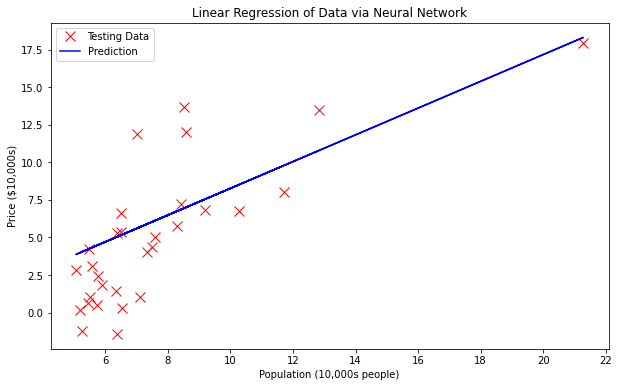

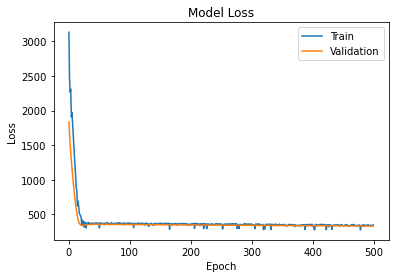

In [184]:
# Problem 4

# Reupload data
f3 = open("pop_data.txt", "r")
data = f3.read().splitlines()[1:]
pop = []
price = []
for tup in data:
    splt = tup.split(",")
    pop.append(float(splt[0]))
    price.append(float(splt[1]))
pop = np.reshape(np.array(pop), (len(pop), 1))
price = np.reshape(np.array(price), (len(price), 1))
print("Population Array Shape:",pop.shape)
print("Price Array Shape:",price.shape)
f.close()

# Split data into training and testing batches
X_train, X_test, y_train, y_test = train_test_split(pop, price, test_size=0.3, random_state=0)

# Define and implement neural network
neurons = 2
lr = 0.00001
num_epochs = 500
print("\nLearning Rate:",lr)
print("Number of Epochs:",num_epochs)

model = Sequential()
model.add(Dense(neurons, activation='relu', input_shape=[1]))
model.add(Dense(1))
opt = optimizers.SGD(learning_rate=lr)
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
model.compile(loss=mse, optimizer=opt)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, verbose=0)
loss = model.evaluate(X_test, y_test, verbose=0)

# Make predictions and compute R^2
x_pred = np.array([[16.5]])
y_pred = model.predict(x_pred, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, y_test_pred),4)
print('\nR-squared score:', r2)
print("Predicted Price of House in City with Population of 165,000: $"+str(round(y_pred[0][0]*10000.00,2)))
    
# Plot data and linear regression
plt.figure(figsize=(10,6))
plt.plot(X_test,y_test,'rx',markersize=10,label='Testing Data')
plt.plot(X_test,y_test_pred,'b-',label = 'Prediction')
plt.ylabel('Price ($10,000s)')
plt.xlabel('Population (10,000s people)')
plt.title("Linear Regression of Data via Neural Network")
plt.legend()
plt.show()

# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The learning curves exhibit a convergence trend, with both training and validation loss decreasing sharply and plateauing, indicating that the model has reached its learning capacity for the current architecture and dataset. Prior learning rate and epoch combinations yielded oscillations in the learning curves, which were mitigated through careful tuning of these hyperparameters. A learning rate of 1e-05 allowed for gradual but stable convergence over 500 epochs, smoothing out the fluctuations that were present with higher learning rates or fewer epochs. Despite these improvements, the R-squared score suggests that the model explains just over half of the variance in the dataset, implying room for further model refinement and hyperparameter tuning to improve predictive performance.